# Trajectory Inference

Using TI methods with dyno for pseudotime like analyses.

In [ ]:
library(tidyverse)
library(dyno)
library(reshape2)
library(viridis)
library(scales)

In [2]:
DAYS = c("D0", "D2", "D4", "D6", "D10", "D12", "D14")

In [299]:
dat = read.table("../20200206_pmat_snapATAC/sessions/20200220_n74838/features.tsv", 
            sep='\t')

In [300]:
head(dat, 2)

,x.sp.sample,umap.1,umap.2,x.sp.cluster,X1,X2,X3,X4,X5,X6,X7,X8,X9
,<fct>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
D0_AAACAACGACGATTAC,D0,6.545686,-7.701751,2,-0.009506306,0.003827220,0.004101834,-0.009462710,0.001698936,-0.006388548,0.004262987,0.003578299,-0.0055907033
D0_AAACAACGACTCACGG,D0,5.180663,-7.633298,2,-0.009003734,0.002892498,0.004525334,-0.004391663,0.000975611,-0.010070413,0.005721408,0.003989271,0.0005145822


In [301]:
# remove doublets/bad cluster if any
# dat = dat[dat$x.sp.cluster!=18,]
dim(dat)

[1] 74838    13

In [288]:
# Take same number of cells from each day
fewest = min(table(dat$x.sp.sample))
idxs = c()

for (d in DAYS) {
    idxs = c(idxs, sample(which(dat$x.sp.sample==d), fewest))
}

dat_red = dat[idxs, ]

In [704]:
# Or take cells from a few days only, sampled 
to_sample = 4000
idxs = c()

for (d in c("D0", "D2", "D4", "D12", "D14")) {
    idxs = c(idxs, sample(which(dat$x.sp.sample==d), to_sample))
}

dat_red = dat[idxs, ]

In [705]:
# Or take cells from a few days only
# dat_red = dat[dat$x.sp.sample %in% c("D0", "D2", "D4"), ]

In [706]:
table(dat_red[, "x.sp.sample"])


  D0  D10  D12  D14   D2   D4   D6   D8 
4000    0 4000 4000 4000 4000    0    0 

In [707]:
# idxs = sample(seq(1,nrow(dat)), 10000)
dataset <- wrap_expression(
  expression =  as.matrix(dat_red[,5:ncol(dat)]),
  counts = as.matrix(dat_red[,5:ncol(dat)])
)

In [708]:
head(sort(rownames(dat_red)))

[1] "D0_AAACAACGACGATTAC" "D0_AAACACGCTACGCCAC" "D0_AAACACGCTAGTACGG"
[4] "D0_AAACACGCTCTTCAAG" "D0_AAACACGCTGATCCAT" "D0_AAACACGCTTAACGAA"

In [709]:
dataset <- add_prior_information(dataset, start_id = "D0_AAACAACGACGATTAC")

In [714]:
model <- infer_trajectory(dataset, ti_paga(filter_features = F, 
                                          n_neighbors = 15L,
                                          n_comps = 12L,
#                                           n_dcs = 0L,
                                          embedding_type="umap"))

In [715]:
# model <- infer_trajectory(dataset, ti_mst(dimred="umap",
#                                           ndim=2))

In [716]:
# plot_dendro(model, grouping = dat[, "x.sp.sample"])

Coloring by grouping



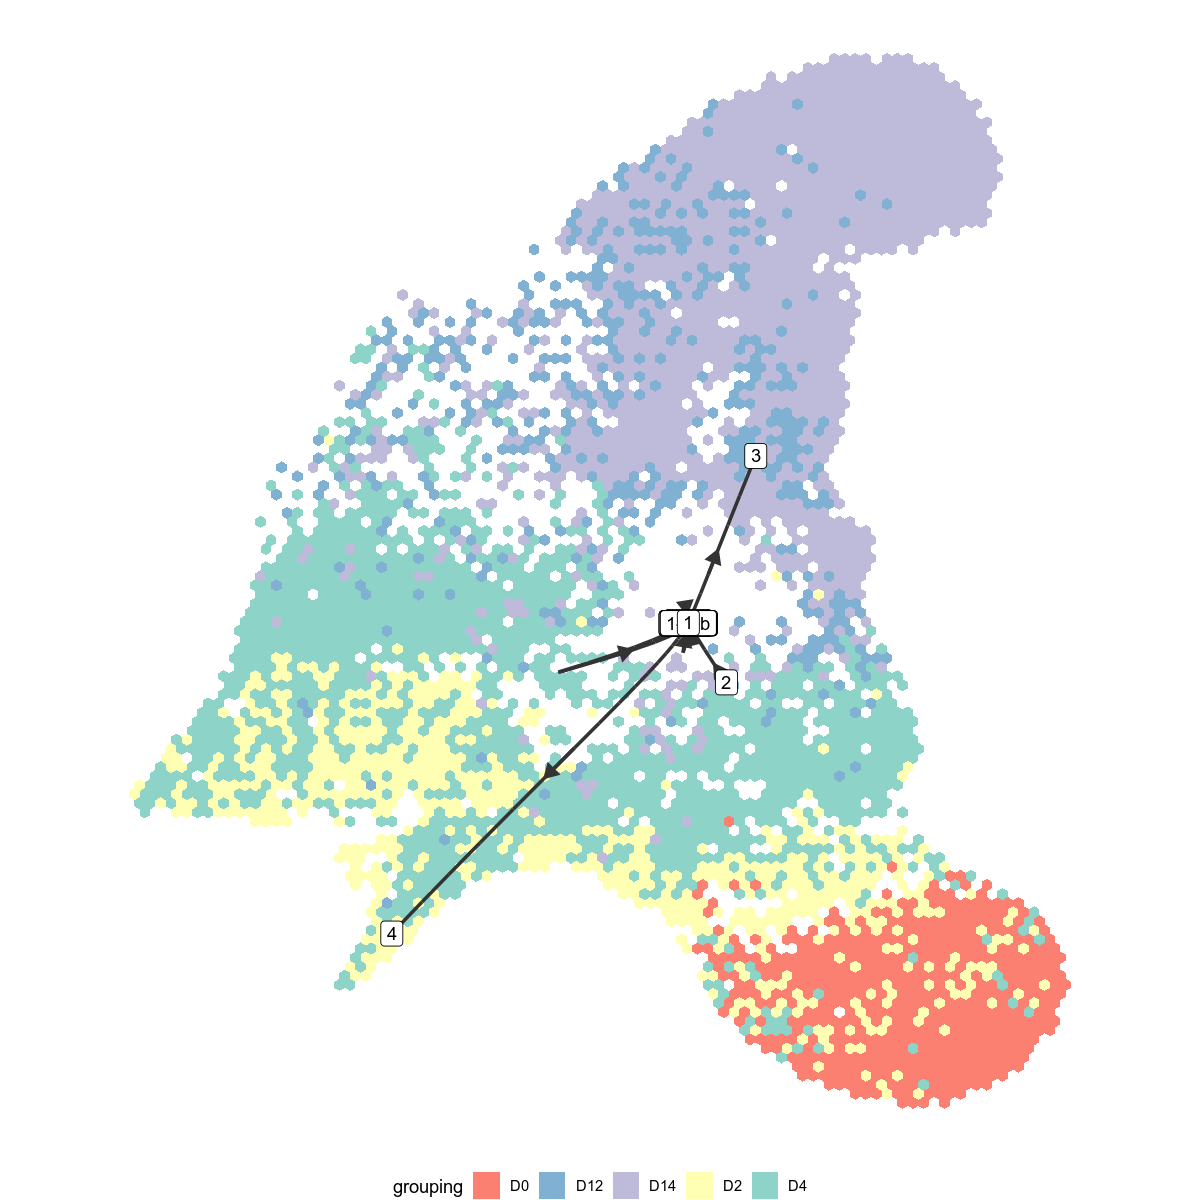

In [717]:
options(repr.plot.width = 10, repr.plot.height = 10)
plot_dimred(model, dimred = as.matrix(dat_red[,c("umap.1", "umap.2")]),
            size_cells = 0.1,
            grouping = dat_red[, "x.sp.sample"],
            label_milestones = T)

In [648]:
simplified <- simplify_trajectory(model)
simplified <- simplified %>% add_root(root_milestone_id = "8")

Coloring by grouping



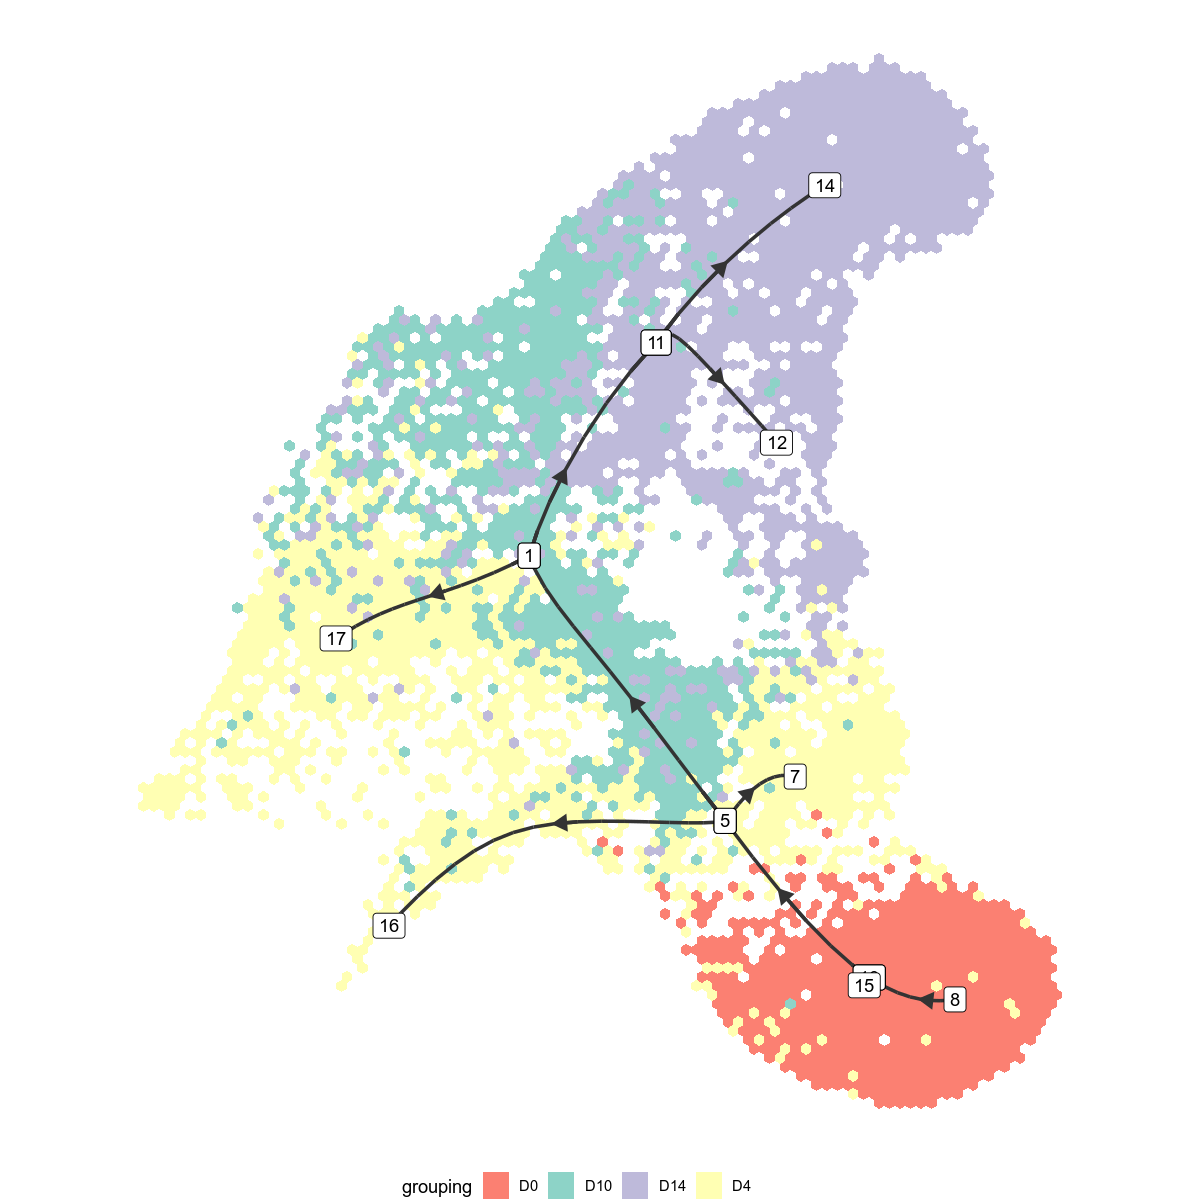

In [649]:
options(repr.plot.width = 10, repr.plot.height = 10)
plot_dimred(simplified, dimred = as.matrix(dat_red[,c("umap.1", "umap.2")]),
            size_cells = 0.1,
            grouping = dat_red[, "x.sp.sample"],
            label_milestones = T)

Pseudotime not provided, will calculate pseudotime from root milestone



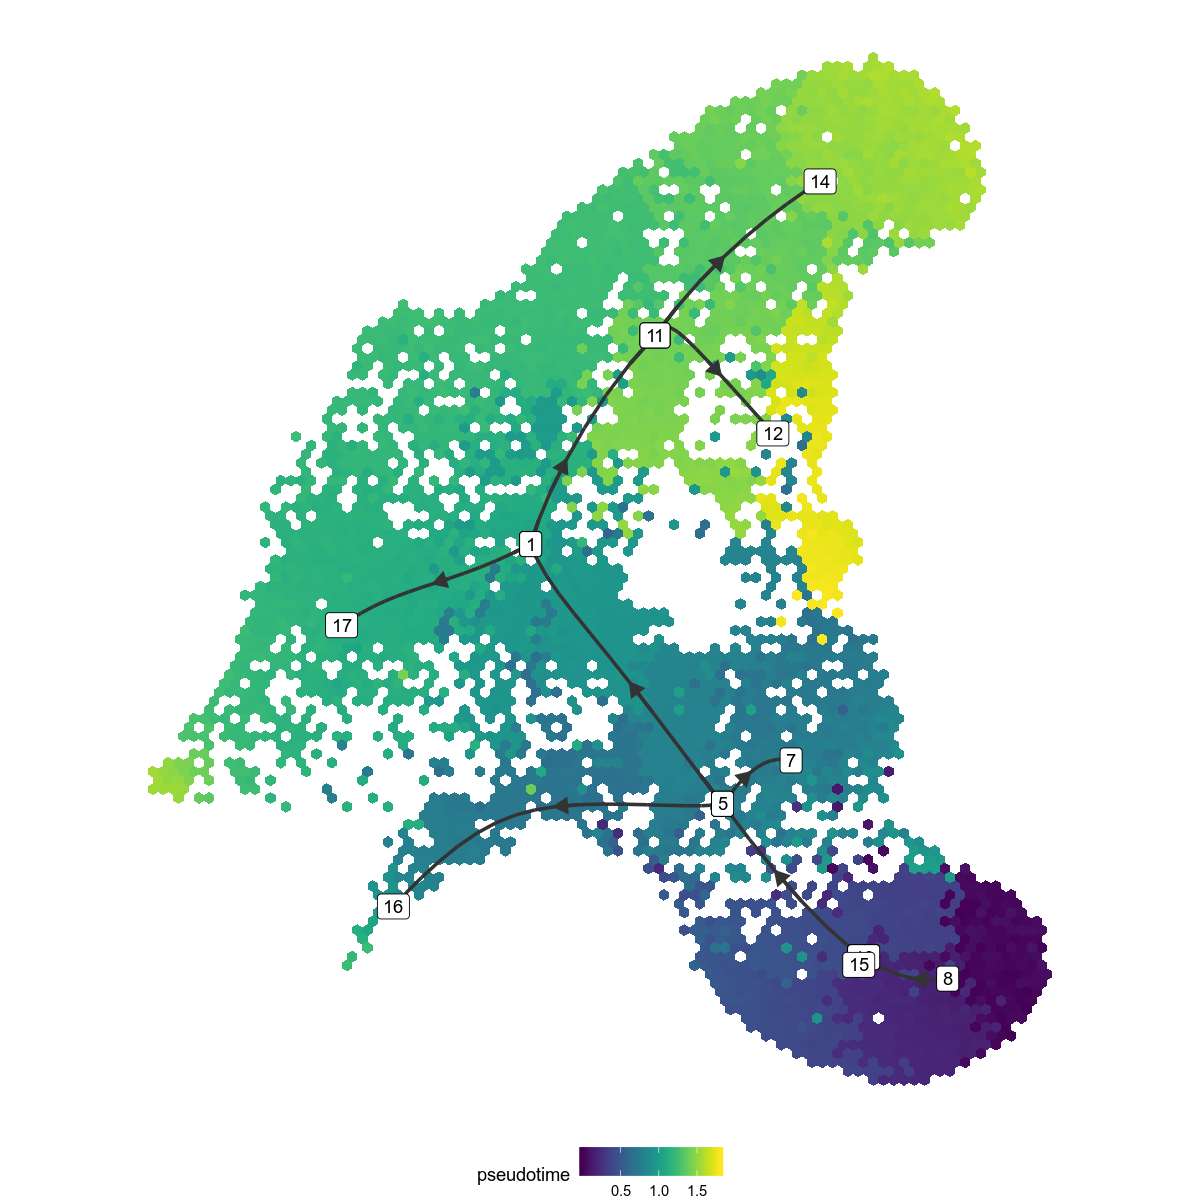

In [650]:
options(repr.plot.width = 10, repr.plot.height = 10)
plot_dimred(simplified, "pseudotime",
            dimred = as.matrix(dat_red[,c("umap.1", "umap.2")]),
            size_cells = 0.1,
            label_milestones = T)

In [651]:
table(simplified$progressions$from)


   1   10   11    5    8 
4035 1633 3614 4351 2367 

Paths:
- To pluripotency are 2 -> 9 -> 8 -> 14
- To keratinocyte are 
- To neural like  are 

In [652]:
nodes = c(8,10,5,1,11,14)
pluripotency_paths = c()
for (i in seq(length(nodes)-1)) {
    pluripotency_paths = c(pluripotency_paths, 
                           sprintf("%d_%d", nodes[i], nodes[i+1]))
}
pluripotency_paths

[1] "8_10"  "10_5"  "5_1"   "1_11"  "11_14"

In [653]:
plu_cells = simplified$progressions[paste(simplified$progressions$from, 
                                   simplified$progressions$to,
                                   sep = '_') %in% pluripotency_paths,]
head(plu_cells)
dim(plu_cells)

,cell_id,from,to,percentage
,<chr>,<chr>,<chr>,<dbl>
2025,D0_GAGGCAATGAGACTTC,10,5,0.1393065
2026,D0_TCGTGAATGCAATGAA,10,5,0.1997123
2027,D0_GCTGGAAGATTGGGAG,10,5,0.0521441
2028,D0_GGCGTACACATTCTGG,10,5,0.2234534
2029,D0_TATGTACCTAAATGCA,10,5,0.2529768
2030,D0_GACGACAGAGGTGCAA,10,5,0.1778252


[1] 9902    4

In [655]:
pseudotime = calculate_pseudotime(simplified)

In [656]:
# sort by order and then by percentage
# plu_cells = plu_cells[order(factor(paste(plu_cells$from, 
#                                         plu_cells$to, 
#                                         sep='_'), 
#                                   levels=pluripotency_paths), 
#                            plu_cells$percentage), ]

# or order by pseudotime
plu_cells = plu_cells[order(pseudotime[plu_cells$cell_id]),]
head(plu_cells)

,cell_id,from,to,percentage
,<chr>,<chr>,<chr>,<dbl>
11951,D0_AAACAACGACGATTAC,8,10,0.000000000
11437,D0_TCCGAGTCTCATACTG,8,10,0.005097807
11702,D0_AGCTCTGCTGCAGTTT,8,10,0.008116864
12146,D0_CCTTTCTACACCATGT,8,10,0.010540197
11408,D0_TACATTCACCCTGCGA,8,10,0.012546163
11983,D0_TGGTCCTTGCCATAAC,8,10,0.013235496


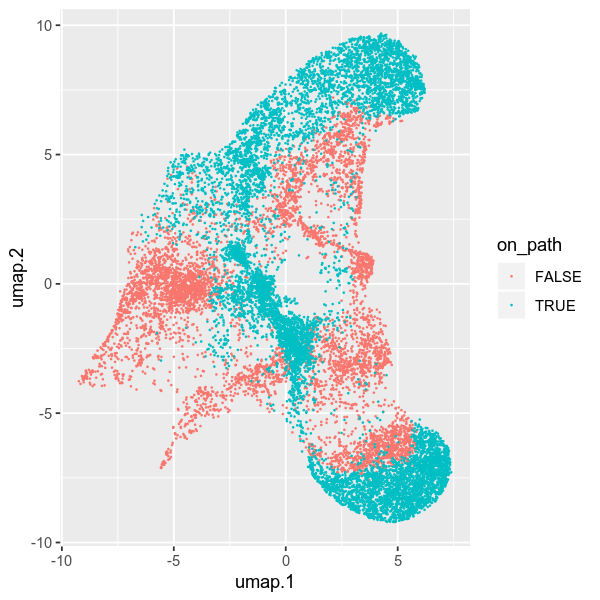

In [657]:
options(repr.plot.width = 5, repr.plot.height = 5)
df = dat_red
df$on_path = rownames(df) %in% plu_cells$cell_id
df = df[order(df$on_path),]

ggplot(data=df,aes(x=umap.1,y=umap.2,color=on_path))+
scale_fill_viridis() +
geom_point(size=0.1)

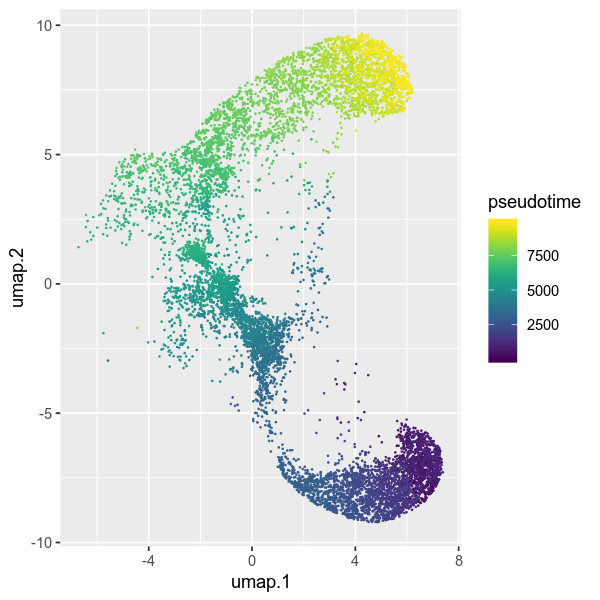

In [658]:
options(repr.plot.width = 5, repr.plot.height = 5)
df = dat_red[plu_cells$cell_id, ]
df[plu_cells$cell_id, "pseudotime"] = seq(1,nrow(plu_cells))
df = df[order(df$pseudotime),]

ggplot(data=df,aes(x=umap.1,y=umap.2,color=pseudotime))+
scale_color_viridis() +
geom_point(size=0.1)

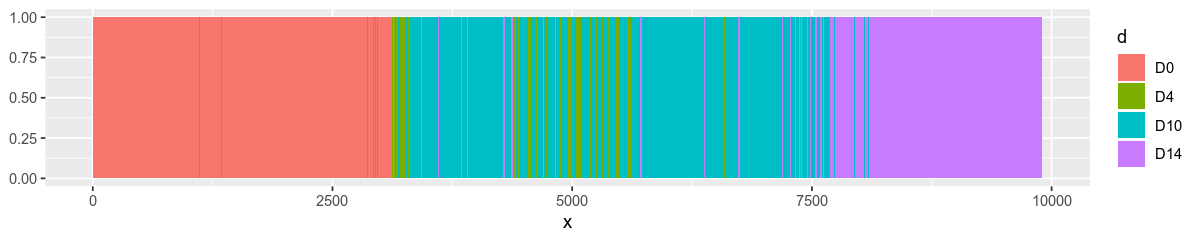

In [659]:
options(repr.plot.width = 10, repr.plot.height = 2)

cur_df = data.frame(x=seq(1,nrow(plu_cells)),
                    d=factor(dat_red[plu_cells$cell_id, "x.sp.sample"],
                            levels=DAYS))
ggplot(cur_df) +
geom_col(aes(x=x, y=1, fill=d),  width=1) +
scale_color_brewer(breaks=DAYS, palette = "Set1") +
ylab(NULL)

## ChromVAR ordered

In [466]:
chromvar = read.table(gzfile("../20200206_pmat_snapATAC/sessions/20200220_n74838/chromvar.tsv.gz"), 
                      sep='\t')
head(chromvar)

,sample,cluster,umap1,umap2,NFIL3,FOXF2,FOXD1,IRF2,MZF1,MZF1.var.2.,⋯,RORC,SOX15,TFE3,VDR,EGR1,IRF3,IRF4,IRF5,TCF7L1,SOX2
,<fct>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
D0_AAACAACGACGATTAC,D0,2,6.545686,-7.701751,-0.06097807,0.12900294,0.122682143,0.023708799,-0.03350387,-0.07210584,⋯,-0.10363258,-0.1276290,0.02889678,-0.0340200459,-0.075238083,0.003078155,0.06416149,-0.002606375,-0.08757322,-0.2251834
D0_AAACAACGACTCACGG,D0,2,5.180663,-7.633298,0.26096212,0.03433481,0.104098022,-0.185325253,-0.08978110,-0.05341638,⋯,0.10424267,-0.2191960,0.17636990,-0.2097924698,-0.008060946,-0.063758849,0.04202541,0.032557515,-0.06418007,-0.1404634
D0_AAACATGGAGACTCGC,D0,14,3.282927,-8.525186,-0.10669436,0.06854084,0.097844393,0.083130153,-0.05967191,-0.01202470,⋯,-0.00557459,-0.1212425,0.04607286,0.0019279775,-0.003432089,-0.002754538,0.16756656,0.160021886,-0.01633408,-0.1156646
D0_AAACATGGATGGGCCT,D0,2,5.934059,-7.776163,-0.10171912,0.10719553,0.002820288,0.004389487,-0.06426016,-0.05802489,⋯,0.01462824,-0.1895438,0.01488373,0.0212876103,-0.060171236,-0.019553484,0.12198716,0.022614238,-0.08929770,-0.2130389
D0_AAACCGTACCTTTAGG,D0,14,2.642430,-8.592471,-0.04850392,0.02195831,-0.016123743,-0.077041036,-0.04410459,-0.03302936,⋯,-0.01220366,-0.1826004,-0.03180454,0.0206026068,-0.017879214,-0.021853683,0.05807207,-0.037356593,-0.10338177,-0.1911633
D0_AAACGAAACCTCGATA,D0,14,3.109288,-8.751338,-0.10340678,-0.01207520,0.012081353,-0.063036310,-0.06229271,-0.07745096,⋯,-0.09863718,-0.1471419,-0.05464891,-0.0004016025,-0.093914726,-0.042500021,0.05470886,-0.008151317,-0.16273989,-0.2358124


In [660]:
motif_df = t(chromvar[plu_cells$cell_id,5:ncol(chromvar)])

# remove NAs
motif_df = motif_df[, colSums(is.na(motif_df))==0]

head(motif_df)
dim(motif_df)

,D0_AAACAACGACGATTAC,D0_TCCGAGTCTCATACTG,D0_AGCTCTGCTGCAGTTT,D0_CCTTTCTACACCATGT,D0_TACATTCACCCTGCGA,D0_TGGTCCTTGCCATAAC,D0_GTTGACTGAGCCCTGA,D0_TACGAGTTGCATTCAG,D0_GGTTCAATGTCTGTAG,D0_TACATTCACCAGGCCT,⋯,D14_GAAGTCTTGGCTCTTC,D14_TCCCTGTGAAAGACAT,D14_ACGTCCACTACGAGCA,D14_CGCTGAGTGCCTGAGC,D14_TCGGGTGACCGGAATG,D14_CCAGGACTGGCGAGTA,D14_TGGGTGCACTCCAGCG,D14_GAACTCCCTCTTAGTG,D14_GGTCTGGACCCGATTA,D14_TGCTAGTGAGCCAGCT
NFIL3,-0.06097807,-0.001421911,-0.05644192,-0.01730845,0.06947016,-0.04886868,-0.046422927,0.08773147,-0.04428635,0.068666799,⋯,0.001463514,0.36481479,-0.01492209,-0.127298674,-0.31821728,0.046432746,-0.017105395,-0.02156220,0.44972740,-0.13758460
FOXF2,0.12900294,0.223237391,0.10650763,0.07298487,0.18688956,0.06979531,0.123731747,0.17243292,0.21501055,0.154628697,⋯,0.130395446,0.24506559,0.48474124,0.203322850,0.36651492,-0.004009524,-0.135330931,0.16819396,0.09558832,0.06665188
FOXD1,0.12268214,0.178140890,0.13146956,0.17611360,0.16350326,0.10712287,0.082655809,0.15935397,0.02319600,0.013163968,⋯,0.230325435,0.52822737,0.69229834,0.551255869,0.51608632,0.012903711,0.015338906,0.36839574,0.17335782,0.28639619
IRF2,0.02370880,0.040785503,0.03113045,-0.03861612,0.09012691,0.02257376,-0.002881618,0.04984807,0.01933340,0.006644571,⋯,-0.039671419,-0.09875491,-0.06435227,0.050144826,0.02216305,0.035338203,-0.097270018,-0.07839787,-0.01211673,0.07287048
MZF1,-0.03350387,-0.057575440,-0.06569727,-0.04708827,-0.05492933,-0.04937960,-0.034367748,-0.04258490,-0.03324022,-0.043347259,⋯,-0.068064158,-0.04865320,0.08544861,0.007046362,0.03164902,-0.026012467,-0.004397722,0.06568443,0.03552741,-0.03279598
MZF1.var.2.,-0.07210584,-0.044641042,-0.03780951,-0.07496681,-0.06164280,-0.01157734,-0.070958939,-0.08708110,0.01085133,-0.039051552,⋯,-0.022918664,-0.15871577,0.12210762,0.252344768,-0.08115607,0.043059014,0.259071145,0.13307101,0.19515487,0.13123455


[1]  453 9848

In [661]:
# z-norm per cell (there seemed to be a trended bias such that most motifs at later days had higher motif scores)
motif_df = scale(motif_df)

# clip quantiles
clip <- function(x){
    quantiles <- quantile( x, c(.05, .95 ) )
    x[ x < quantiles[1] ] <- quantiles[1]
    x[ x > quantiles[2] ] <- quantiles[2]
    x
}

motif_df = t(apply(motif_df, 1, clip))

# scale to 0-1
motif_df = motif_df - apply(motif_df, 1, min)
motif_df = motif_df/apply(motif_df, 1,max)

In [662]:
# smooth
motif_df_smooth = t(apply(motif_df, 1, smooth))
colnames(motif_df_smooth) = colnames(motif_df)
motif_df = motif_df_smooth
dim(motif_df)

[1]  453 9848

In [663]:
# take subset
# tf_list = c("POU5F1", "SOX2", "KLF4", "ZBTB7B", "CTCF", "YY1", "TFAP2B", 
#                      "BACH2", "JUNB", "FOXC2", "FOXB1", "ATF4", "JUN", "CEBPA")
# motif_df = motif_df[tf_list, ]

In [664]:
# order rows (motifs)
row_distance = dist(t(scale(t(motif_df))))
row_cluster = hclust(row_distance, method="ward")
row_dendrogram = as.dendrogram(row_cluster)
rowInd = rev(order.dendrogram(row_dendrogram))

motif_df_row_ordered = as.matrix(motif_df[rowInd, ])
head(motif_df_row_ordered, 2)

The "ward" method has been renamed to "ward.D"; note new "ward.D2"



,D0_AAACAACGACGATTAC,D0_TCCGAGTCTCATACTG,D0_AGCTCTGCTGCAGTTT,D0_CCTTTCTACACCATGT,D0_TACATTCACCCTGCGA,D0_TGGTCCTTGCCATAAC,D0_GTTGACTGAGCCCTGA,D0_TACGAGTTGCATTCAG,D0_GGTTCAATGTCTGTAG,D0_TACATTCACCAGGCCT,⋯,D14_GAAGTCTTGGCTCTTC,D14_TCCCTGTGAAAGACAT,D14_ACGTCCACTACGAGCA,D14_CGCTGAGTGCCTGAGC,D14_TCGGGTGACCGGAATG,D14_CCAGGACTGGCGAGTA,D14_TGGGTGCACTCCAGCG,D14_GAACTCCCTCTTAGTG,D14_GGTCTGGACCCGATTA,D14_TGCTAGTGAGCCAGCT
EGR2,0.4378153,0.4378153,0.4378153,0.4378153,0.5018688,0.5018688,0.4086116,0.4086116,0.4086116,0.4086116,⋯,0.5549922,0.7909266,0.7909266,0.7909266,0.6019050,0.6019050,0.6019050,0.6019050,0.6019050,0.6019050
ZBTB33,0.4573037,0.4573037,0.4573037,0.4573037,0.4582105,0.5388094,0.5388094,0.5388094,0.5388094,0.5388094,⋯,0.8768480,0.8768480,0.8768480,0.8236459,0.7432037,0.7172417,0.5819167,0.4667939,0.4667939,0.4667939


In [665]:
# motif_df_row_ordered = motif_df[order(rowSums(
#             motif_df[,as.integer(ncol(motif_df)*.75):ncol(motif_df)])),]

# motif_df_row_ordered = motif_df[order(
#                     apply(motif_df, 1, function (x) {median(which(x>0.75))}) - apply(motif_df, 1, function (x) {median(which(x<=0.75))})
#                 ),]

In [668]:
melted = melt(motif_df_row_ordered[, seq(1,ncol(motif_df_row_ordered), 10)])
melted$Var1 = factor(melted$Var1, levels=rownames(motif_df_row_ordered))
melted$Var2 = factor(melted$Var2, levels=colnames(motif_df_row_ordered))

In [669]:
head(melted, 2)

,Var1,Var2,value
,<fct>,<fct>,<dbl>
1,EGR2,D0_AAACAACGACGATTAC,0.4378153
2,ZBTB33,D0_AAACAACGACGATTAC,0.4573037


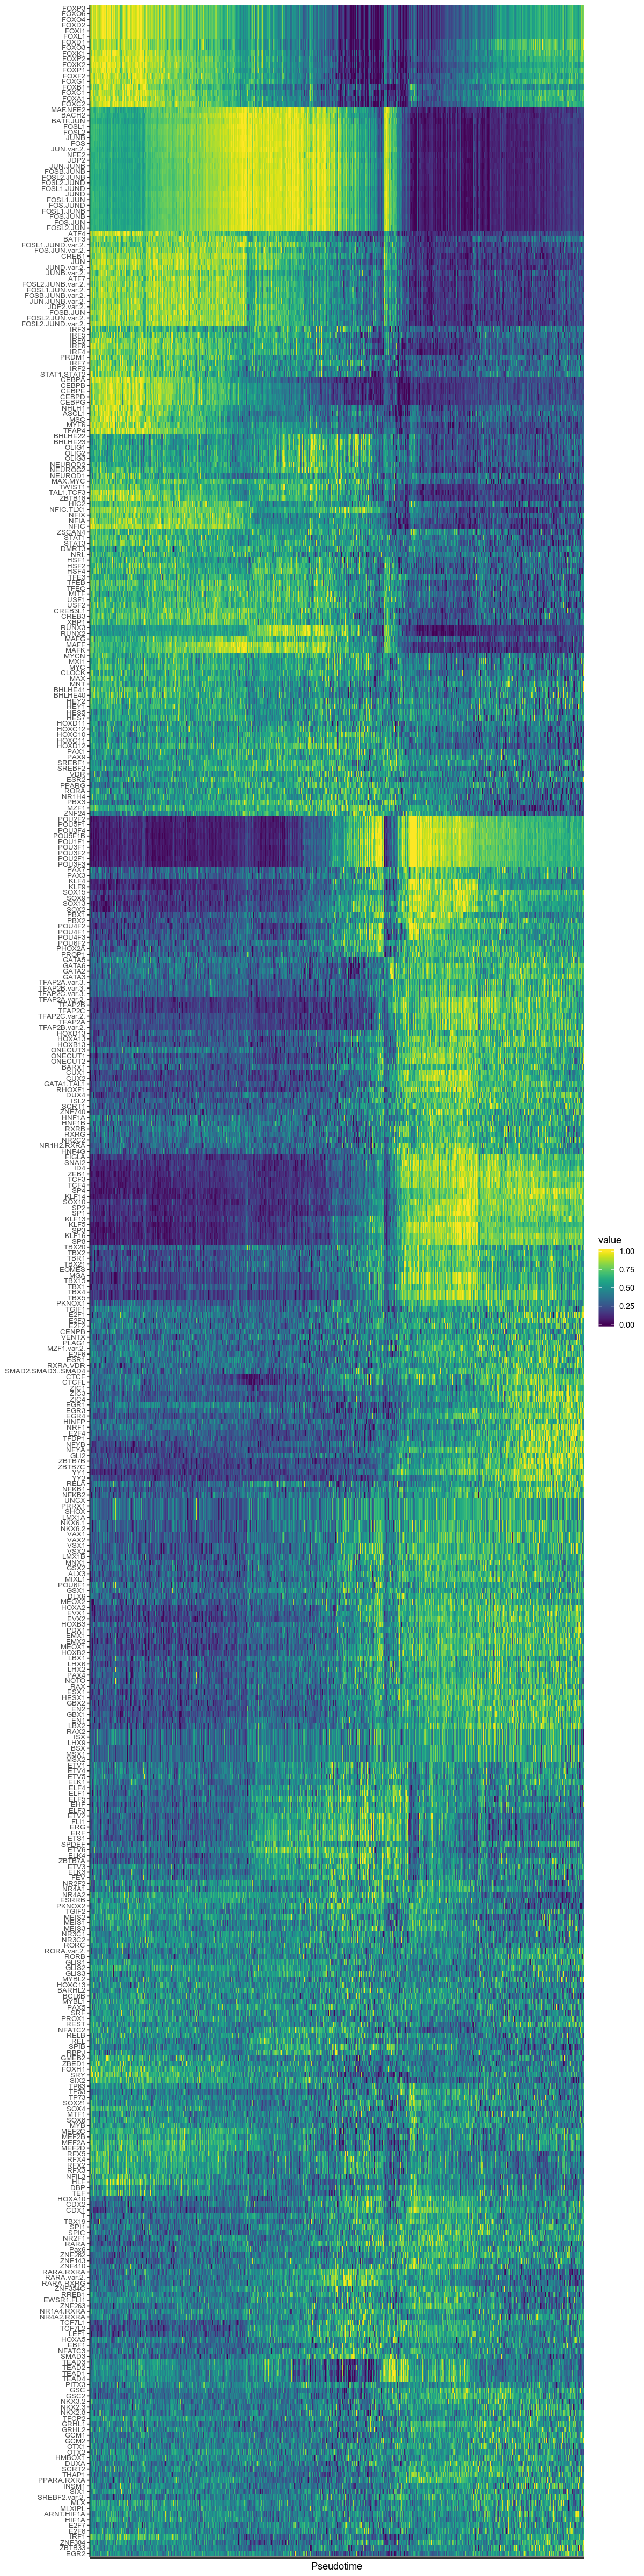

In [670]:
options(repr.plot.width = 10, repr.plot.height = 40)

ggplot(data = melted, mapping = aes(x = Var2,
                                    y = Var1,
                                    fill = value)) +
geom_tile()  + ylab(NULL) + xlab("Pseudotime") +  
geom_raster(aes(fill=value)) +
# scale_fill_viridis(limits=c(-1, 1), oob=squish, option = "B") +
# scale_fill_gradient(limits=c(-0.5,0.5), oob=squish, low="blue4", high="yellow") +
scale_fill_viridis(limits=c(0,1), oob=squish) +
# facet_grid(sort(pr_mb)[idxs] ~ ., switch = "y", scales = "free_y", space = "free_y") +
theme_classic() +
theme(axis.text.x=element_blank(),
      axis.text.y=element_text(angle=0,hjust=1, size=8),
#       axis.ticks.y=element_blank(),
#       panel.spacing.y = unit(0.03, "cm"),
      strip.text.y = element_text(size = 3)) 
#       strip.background = element_rect(size = 0.1))

# ggsave(sprintf("figs/%s_pluripotency_pseudotime_chromvar.jpeg", format(Sys.Date(), format='%Y%m%d')),
#        width = 15, height = 5, dpi=300)